# Perplexity-based subsampling of a dataset


In [2]:
%matplotlib inline

import lzma
import tarfile

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('ggplot')
#plt.style.use('bmh')
plt.style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = (14,8)

In [3]:
plt.rcParams.update({'font.size': 12})

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
from typing import List, Tuple

# TL;DR

* **Objetive**: we have a dataset with an arbitrary perplexity distribution. We want to subsample that dataset in a way that we 
   - achieve a predefined sampling ratio R 
   - increase the share of the dataset having central perplexity distributions.
     We define "central" as the perplexities in the two middle quartiles of the original distribution, i.e. interval $[p_{25}$, $p_{75}$]. 
   - In concrete terms, given the perplexity values at these quartiles, $X_a$ and $X_b$, we will want to modify the share of those regions from 25% to other values $p_a$ and $p_b$
   
* **Method**:
   - compute $X_a$ and $X_b$, the perplexity values for $p_{25}$ and $p_{75}$
   - define an initial Gaussian weighting curve as a Gaussian PDF having its $p_{25}$ and $p_{75}$ values in the same $X_a$ and $X_b$ positions as the computed ones
   - compute a histogram of the perplexities
   - use the histogram + initial Gaussian weights to estimate the sampling ratio that would result, and extract from it the normalization factor needed to achieve R
   - modify the paremeters of the initial Gaussian curve by minimizing the error on the desired probabilities $p_a$ and $p_b$
   - subsample the dataset by comparing the perplexity of each sample against the modified normalized Gaussian curve to estimate the probability of retaining it
   
A final class that implements this procedure is defined in the [PerplexitySubsampler](../subsampler.py) file and it is used in another, [self-contained notebook](gaussian_subsampling.ipynb). The **Development** section in this notebook details the process step by step.

# Development

## 1. Data loading 

We start by loading the computed perplexity values of the dataset (in this case computed over a 50M random sample)

In [4]:
data = []
with open("../scores/culturax_da.jsonl") as f:
    for line in f:
        data.append(json.loads(line)["perplexities"]["wikipedia_pp"])

data = np.array(data)
len(data)

50000000

Compute quartiles

In [5]:
qr = np.quantile(data, [0.25, 0.50, 0.75])
qr

array([542497.86733512, 679167.90234057, 998401.07723076])

Plot the distribution, together with its quartiles

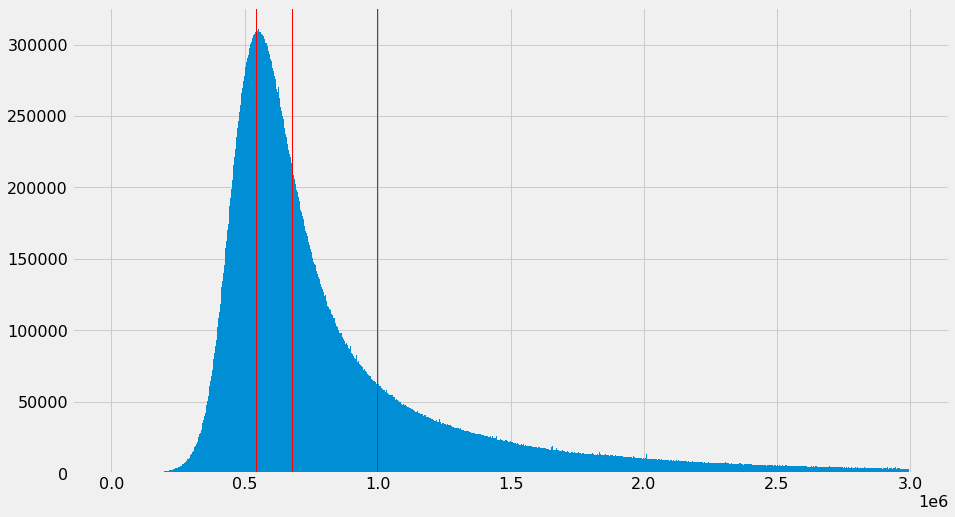

In [6]:
fig, ax = plt.subplots()
ax.hist(data, bins=1000, range=[0, qr[2]*3]);
#ax.set_title("perplexity for a random sample of mC4-es (P95 of 44M values)");
#ax.get_yticklabels().set_fontsize(9)
for q in qr:
    ax.axvline(q, c='r', lw=1)

## 2. Data subsampling procedure

### 2.1 Overall objective


We define three regions in the perplexity distribution:
1. Low perplexity: the region below the $p_{25}$ percentile
2. Mid perplexity: the central region between the $p_{25}$ percentile and the $p_{75}$ percentile
3. High perplexity: the region beyond the $p_{75}$ percentile

The objective is to reshape the dataset so that when subsampled we transfer probability mass from regions [1] and [3] to region [2]


We use then two points in the perplexity distribution:
* $X_a$ is the perplexity value for the $p_{25}$ percentile
* $X_b$ is the perplexity value for the $p_{75}$ percentile

### 2.2 Gaussian weighting

With this procedure, we will use a Gaussian curve to extract the weights for subsampling

In [7]:
from scipy.stats import norm, uniform

We now design a normal distribution having a probability distribution so that 
* a certain probability mass (which will be less than the original 25%) is below $X_a$
* a certain probability mass (which will be less than the original 25%) is beyond $X_b$

By moving probability away from the original $p_{25}$ (i.e. $X_a$) and $p_{75}$ (i.e. $X_b$) perplexities, we are going to achieve our aim of reweighting the dataset decreasing the amount of low and high perplexities

#### parameters of the initial Gaussian curve

In [8]:
pa = 0.15  # probability fraction we will want below Xa -- should be less than 0.25
pb = 0.10  # probability fraction over Xb -- should be less than 0.25

The way of computing the desired normal distribution is by inserting those two values into the Gaussian CDF formula, and deducing from the two equations the values of the Gaussian parameters $\mu$ and $\sigma$

<table style="font-size: 140%; text-align: left;">
<tr style="background: white;">
<td style="text-align: left;">
    
$ \phi ( \frac{X_{a} − \mu}{\sigma} ) = p_a $

</td><td>

$\Rightarrow$

</td><td style="text-align: left;">

$X_{a} − \mu = \sigma \cdot \phi^{-1}(p_a)$

</td>
</tr><tr>
<td>

$ \phi ( \frac{X_{b} − \mu}{\sigma} ) = 1 - p_b $

</td><td>
    
$\Rightarrow$

</td><td>
    
$X_{b} − \mu = \sigma \cdot \phi^{-1}(1 - p_b)$

</td>
</tr>
</table>

In [9]:
# Standard deviation
sdev = (qr[0] - qr[2]) / (norm.ppf(pa) - norm.ppf(1-pb))

# Mean
mean = qr[0] - norm.ppf(pa)*sdev

Let's plot the CDF for the normal distribution we have created

In [10]:
x = np.linspace(0, qr[2]+qr[0], 5000)
y = norm.cdf(x, loc=mean, scale=sdev)

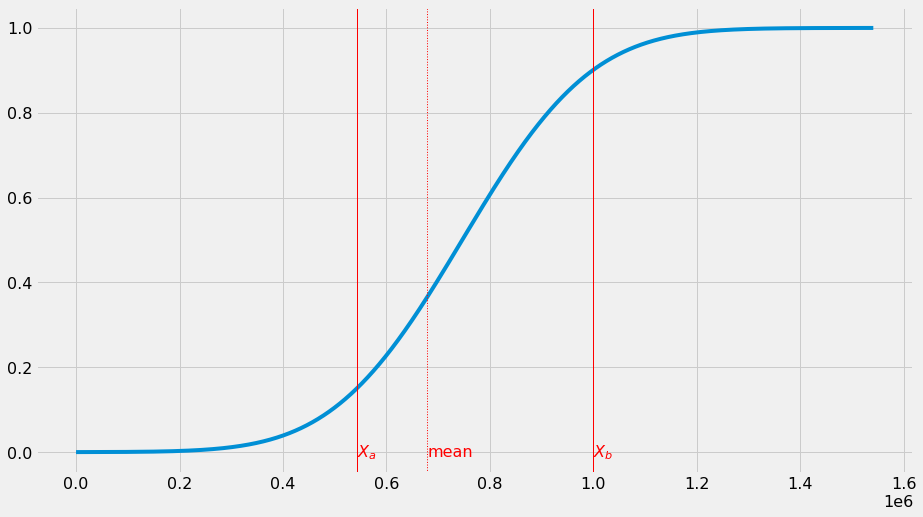

In [11]:
fig, ax = plt.subplots()
ax.plot(x, y);
for q, t, s in zip(qr, ["$X_a$", "mean", "$X_b$"], ["-", ":", "-"]):
    ax.axvline(q, c='r', lw=1, ls=s)
    ax.text(q, -0.01, t, color="r")

We can verify that effectively the aggregated probabilities for our extreme intervals $X_a$ and $X_b$ are as defined by $p_a$ and $p_b$

In [12]:
# Check the probabilities for the regions delimited by Xa & Xb
norm.cdf(qr[0], loc=mean, scale=sdev), norm.cdf(qr[2], loc=mean, scale=sdev)

(0.1499999999999999, 0.8999999999999999)

And its PDF is as follows:

In [13]:
def plot_quartiles(ax: plt.Axes):
    for q, s in zip(qr, ["-", ":", "-"]):
        ax.axvline(q, c='r', lw=1, ls=s)

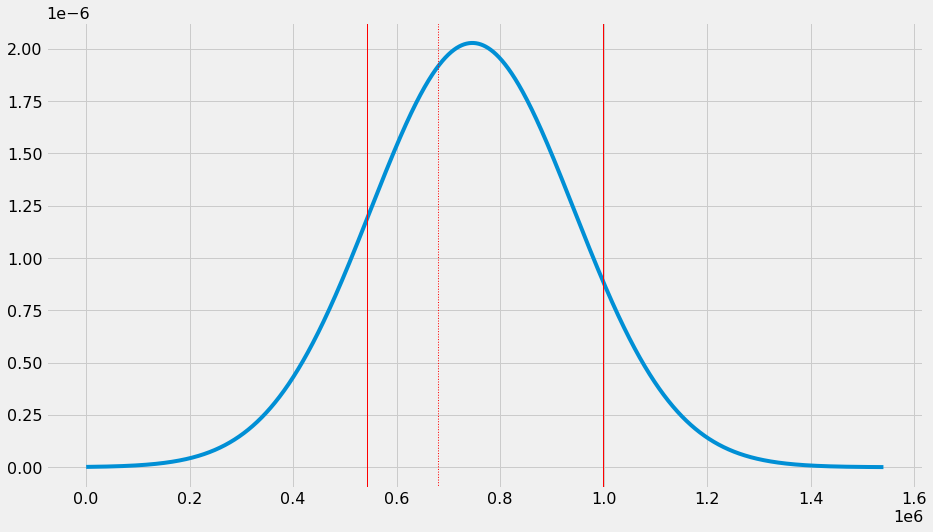

In [14]:
gauss_pdf = norm.pdf(x, loc=mean, scale=sdev)

fig, ax = plt.subplots()
ax.plot(x, gauss_pdf);
plot_quartiles(ax)

As it should be, the area under the PDF curve is 1 (since the total probability mass must sum to 1)

In [15]:
sum(gauss_pdf)*(x[1]-x[0])

0.9998996644500662

And the maximum value of the Gaussian curve is at the mean of the PDF

In [16]:
pdf_max = np.max(gauss_pdf)

In [17]:
pdf_max, norm.pdf(mean, loc=mean, scale=sdev)

(2.0283737486698773e-06, 2.0283739702357006e-06)

In our initial try, the Gaussian curve that we will use for weighted resampling is the PDF of the gaussian distribution just computed, but normalized so that its maximum (the mean of the Gaussian) equals 1. That means that items with that perplexity will be sampled with probability 1 (i.e will _not_ be subsampled), and the weight will decrease gradually as we get away from that mean

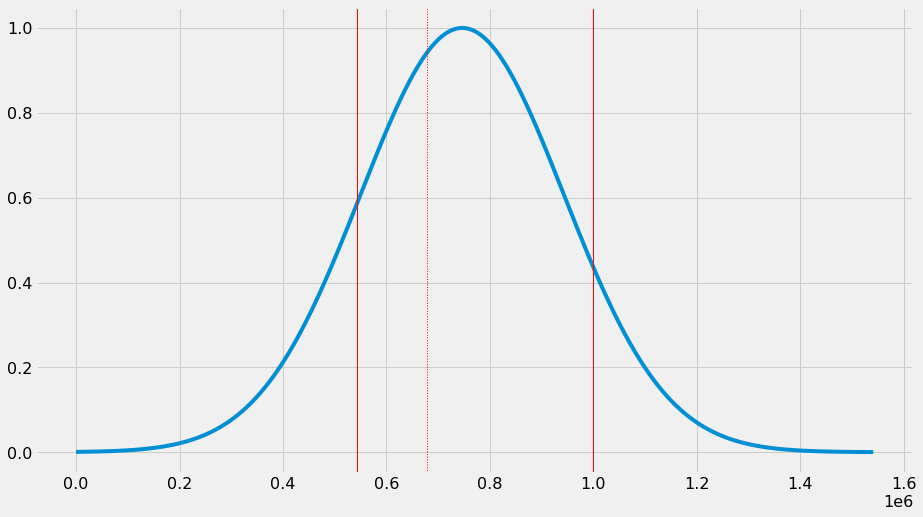

In [18]:
fig, ax = plt.subplots()
ax.plot(x, gauss_pdf/pdf_max);
plot_quartiles(ax)

## 3. Apply subsampling to uniform data

To test the process, we are going to apply it to data with uniform probability. We'll use as working interval (0, $X_{a} + X_{b}$). This interval is chosen so that the uniform data has originally a 25% probability mass below $X_a$ and a 25% probability mass above $X_b$, i.e. just as the original dataset did

### 3.1 Generate uniform data

In [19]:
interval = [0, qr[2]+qr[0]]
width = interval[1] - interval[0]

In [20]:
# we generate random data on the interval 
data_unif = uniform.rvs(*interval, 300000)

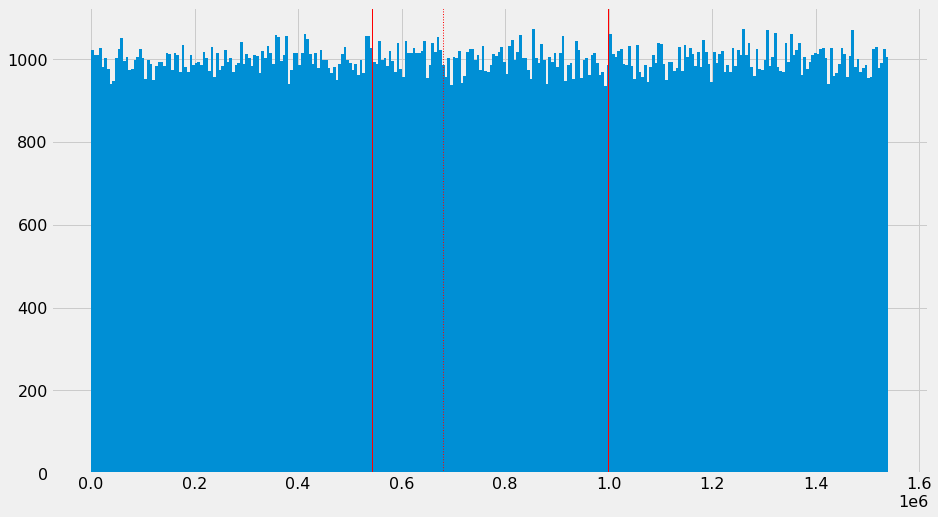

In [21]:
# Let's plot the distribution for the test data. Should be flat
fig, ax = plt.subplots()
ax.hist(data_unif, bins=300);
plot_quartiles(ax)

### 3.2 subsample
We define now the subsampling function with gaussian weighting

In [22]:
def subsample_gauss(data: np.ndarray, mean: float, sdev: float, norm_factor: float) -> np.ndarray:
    """
    Vectorized subsampling: process the whole dataset
    """
    # Create the gaussian weight for each data point
    p = norm.pdf(data, loc=mean, scale=sdev)/norm_factor
    #print(p)
    # Subsample data with probability according to the weight
    return data[ uniform.rvs(size=len(p)) < p ]

After resampling, at each perplexity value, the probability of retaining a sample will be the value of the normalized gaussian PDF curve.

This also means that the overall sample ratio will be:

<div style="font-size: 120%;">
<table><tr><td>

$$\text{R} = \int{p(v) \cdot w(v) dv} = 
\int{ p(v) \cdot \frac{1}{\text{pdf}_{max}} \text{pdf}(v) dv } = 
$$

</td></tr><tr><td>

$$ = { \frac{1}{W} \cdot \frac{1}{\text{pdf}_{max}} \text{pdf}(v) dv } = 
\frac{1}{W\cdot\text{pdf}_{max}}\int{\text{pdf}(v) dv} =
\frac{1}{W\cdot\text{pdf}_{max}}$$

</td></tr></table>
    
where $W$ is the interval width, and we use the value of the uniform probability ($1/W$) and the fact that the integral of the Gaussian distribution over the interval sums approximately 1 (given that the interval is big enough to encompass most of the Gaussian definition interval)
</div>

In [23]:
ratio = 1/(width*pdf_max)
ratio

0.31994686644840487

Let's do the resampling:

In [24]:
data_unif_sub = subsample_gauss(data_unif, mean, sdev, pdf_max)

### 3.3 check results

Check the obtained sampling ratio; it should be aproximately equal to the estimation:

In [25]:
len(data_unif_sub)/len(data_unif)

0.3208933333333333

Check the shares of the distribution below $X_a$ and above $X_b$, they should match our objectives

In [26]:
def check_regions(data: np.ndarray):
    ra = len(data[data < qr[0]]) / len(data)
    print("Probability mass below Pa:", ra)
    rb = len(data[data > qr[2]]) / len(data)
    print("Probability mass above Pb:", rb)

In [27]:
check_regions(data_unif_sub)

Probability mass below Pa: 0.14987327045331783
Probability mass above Pb: 0.1009785183030706


We can plot the resulting data distribution

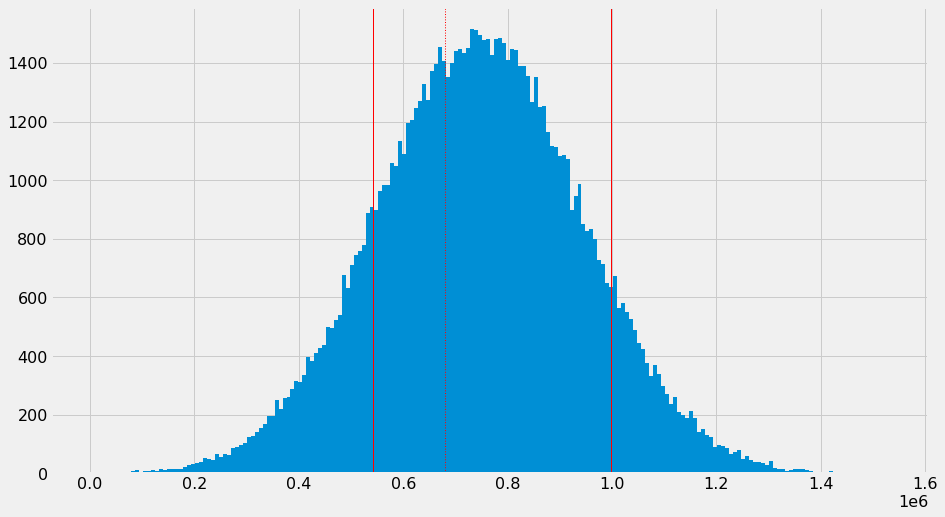

In [28]:
fig, ax = plt.subplots()
ax.hist(data_unif_sub, bins=200);
plot_quartiles(ax)

### 3.4 Adjust sampling ratio

The "natural" sampling ratio for this Gaussian weighting obtained is, as computed above, of 32%. We might want to achieve a different sampling ratio; to achieve that we can modify the normalization factor so that we lower the Gaussian curve to sample less data (but still keep the relative weights); in this case the peak of the Gaussian would not sample at 100%, but less than that.

In [29]:
# Let's seek a sampling ratio of 20%
desired_sampling_ratio = 0.20

# With this desired fraction, we compute the new normalization factor
unif_norm_factor = 1/(width*desired_sampling_ratio)

In [30]:
data_unif_sub2 = subsample_gauss(data_unif, mean, sdev, unif_norm_factor)

In [31]:
# Now we have our desired sampling ratio
len(data_unif_sub2)/len(data_unif)

0.20069666666666666

In [32]:
# And the probability masses stay as before
check_regions(data_unif_sub2)

Probability mass below Pa: 0.14976166353867362
Probability mass above Pb: 0.1011808865784185


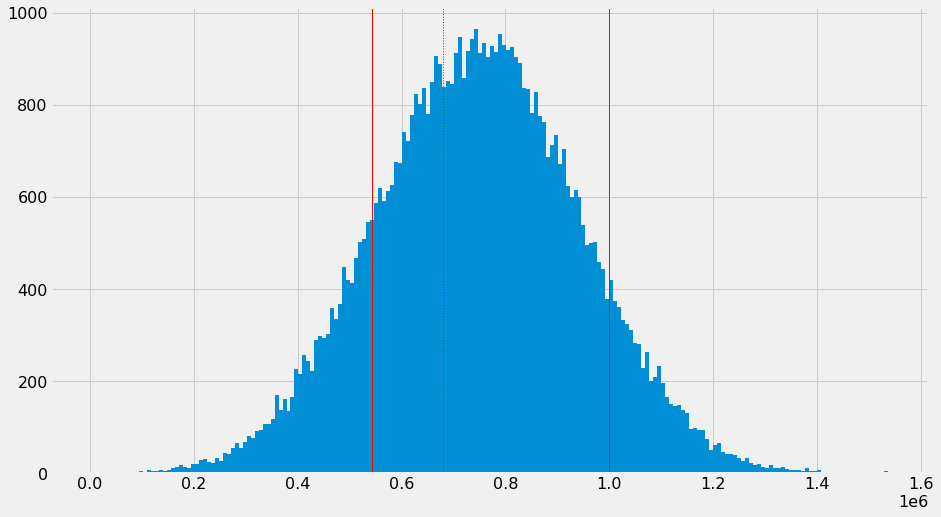

In [33]:
fig, ax = plt.subplots()
ax.hist(data_unif_sub2, bins=200);
plot_quartiles(ax)

## 4. Subsample the original dataset

### 4.1 Direct approach

We now apply the same procedure to our original (non-uniform) dataset, using the same normalization factor we used for the uniform dataset

In [34]:
%%time
data_sub = subsample_gauss(data, mean, sdev, unif_norm_factor)

CPU times: user 3.64 s, sys: 57.9 s, total: 1min 1s
Wall time: 1min 1s


In [35]:
# Compute the sampling ratio we have achieved
len(data_sub)/len(data)

0.32652108

We did not actually achieve the desired sampling ratio. Let's take a look at the resulting perplexity distibution, comparing it with the original

In [36]:
def plot_subsample(orig: np.ndarray, sub: np.ndarray, 
                   name: str = 'Gaussian subsampling'):
    fig, ax = plt.subplots()
    if orig is not None:
        ax.hist(orig, bins=1000, range=[0, qr[2]*3]);
    ax.hist(sub, bins=1000, range=[0, qr[2]*3], color="g");
    if orig is not None:
        ax.legend(['original', 'subsampled'])
    plot_quartiles(ax)
    ax.set_title("Perplexity distribution " + ("before and after " if orig is not None else "for ") + name);

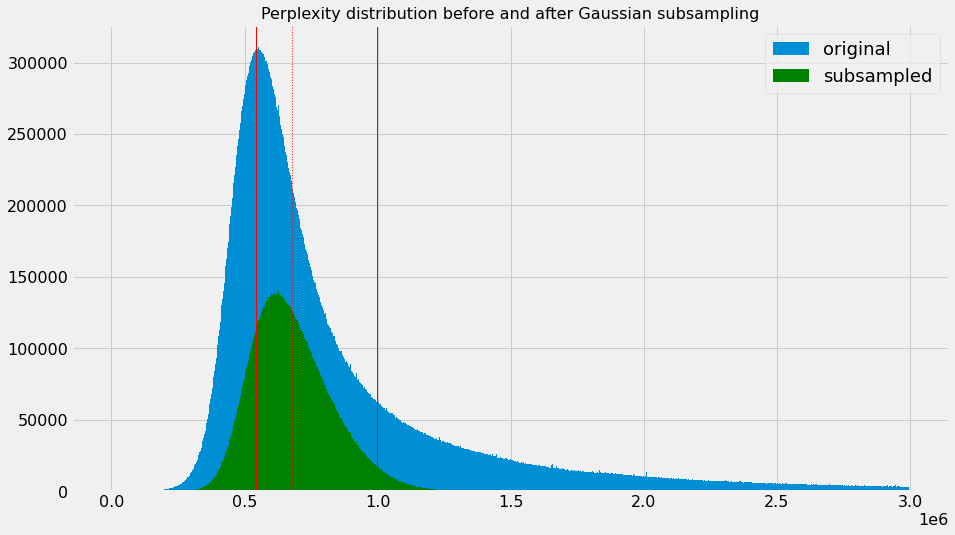

In [37]:
plot_subsample(data, data_sub)

### 4.2 Adjust sampling ratio

In order to achieve the desired sampling ratio, we now muct take into account that now the data distribution is not uniform, hence the previous simple computation no longer applies. 

Instead, we need to compute the sampling ratio from the full integral. In order to approximate it, we compute an histogram of the data and appliximate the integral through a sum over the histogram bins

In [38]:
# Compute a histogram for the dataset
hbins = 1000
range_max = qr[2]*10
hcounts, hedges = np.histogram(data, bins=hbins, range=[0, range_max])
hcounts[-1] += len(data[data>range_max])

hperp = (hedges[:-1] + hedges[1:])/2

In [39]:
# Now let's compute the gaussian weighting function over the histogram bins
gauss_weights = norm.pdf(hperp, loc=mean, scale=sdev)

In [40]:
# And we estimate the sampling ratio by a sum
samples = (hcounts*gauss_weights/unif_norm_factor).sum()

samples/hcounts.sum()

0.3265025569497173

This theoretical number is a good approximation to the one obtained from the actual sample. So, we use this procedure in the reverse, to compute the normalization factor we need to achieve the desired sampling ratio

In [41]:
adjusted_norm_factor = (hcounts*gauss_weights).sum()/hcounts.sum()/desired_sampling_ratio

In [42]:
%%time
data_sub_adjusted = subsample_gauss(data, mean, sdev, adjusted_norm_factor)

CPU times: user 3.35 s, sys: 38.4 s, total: 41.8 s
Wall time: 42 s


In [43]:
# Obtained ratio
len(data_sub_adjusted)/len(data)

0.19998344

... the ratio now is close to the desired factor. The resulting distribution is as follows:

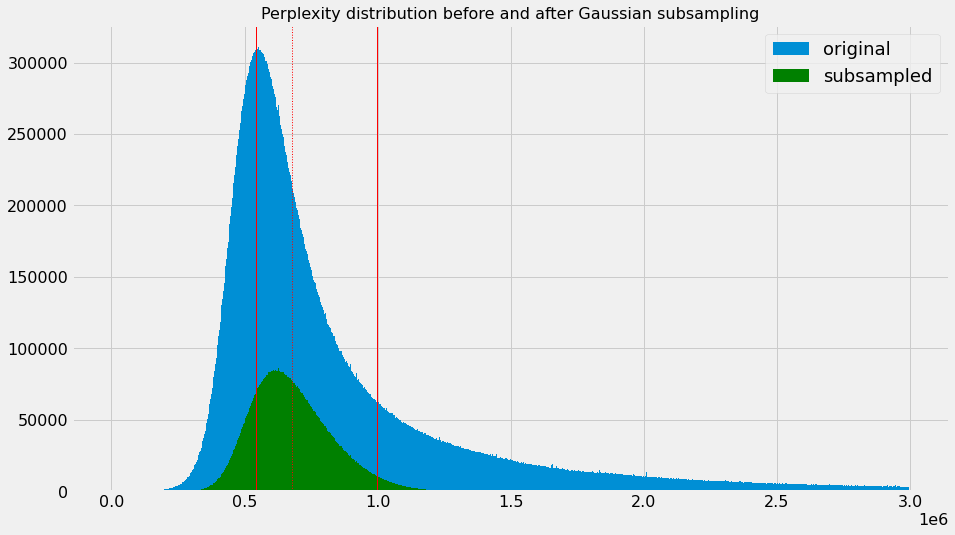

In [44]:
plot_subsample(data, data_sub_adjusted)

The probability masses, though, have not been adjusted to our original objectives:

In [45]:
check_regions(data_sub_adjusted)

Probability mass below Pa: 0.18007621031021367
Probability mass above Pb: 0.0318859401558449


In [46]:
abs(pa-0.1801) + abs(pb-0.03183)

0.09827000000000002

The transfer of probability mass is, in fact, greater than oour objectives of retaining a 15% and 10%. 

This is to be expected, given the non-uniform probability of the data. So the simple global computation we did is no longer valid. If we want to evaluate the actual probability masses in the regions given by $X_a$ and $X_b$ we need to compute the actual integral, or apporximate it by histogram sums

## 4.3 Modification of the Gaussian weighting curve

If we modify the `mean` and `sdev` Gaussian parameters from the ones estimated for uniform data probability , we can change the probability masses to be transferred:
 * modify sdev changes the results for both regions, transferring more or less data from them
 * while moving the mean changes the relation asymmetrically, giving more weight to the first or to the fourth quartile

 
### 4.3.1 Subsample with different parameter combinations

Let's try a grid of values around the initial values

In [47]:
def compute_subsample_results(data, m: float, s: float) -> Tuple[float, float, float]:
    # Gaussian weigthing
    gauss_weights = norm.pdf(hperp, loc=m, scale=s)
    adjusted_norm_factor = (hcounts*gauss_weights).sum()/hcounts.sum()/desired_sampling_ratio
    # Subsample
    data_sub = subsample_gauss(data, m, s, adjusted_norm_factor)
    # Compute result metrics
    ra = len(data_sub[data_sub < qr[0]]) / len(data_sub)
    rb = len(data_sub[data_sub > qr[2]]) / len(data_sub)
    return len(data_sub)/len(data), ra, rb

In [48]:
%%time
df = pd.DataFrame(([f1, f2, mean*f1, sdev*f2, *compute_subsample_results(data, mean*f1, sdev*f2)]
                   for f1 in np.arange(0.8, 1.3, 0.1) for f2 in np.arange(0.8, 1.3, 0.1)), 
                  columns=["factor1", "factor2", "mean", "sdev", "ratio", "pa", "pb"])

CPU times: user 1min 32s, sys: 14min 21s, total: 15min 53s
Wall time: 16min


In [49]:
df

factor1  factor2           mean           sdev     ratio        pa  \
0       0.8      0.8  597075.559089  157344.665729  0.199987  0.327361   
1       0.8      0.9  597075.559089  177012.748946  0.200060  0.330927   
2       0.8      1.0  597075.559089  196680.832162  0.200115  0.332619   
3       0.8      1.1  597075.559089  216348.915378  0.200093  0.332710   
4       0.8      1.2  597075.559089  236016.998594  0.200026  0.331974   
5       0.9      0.8  671710.003975  157344.665729  0.199982  0.219279   
6       0.9      0.9  671710.003975  177012.748946  0.200027  0.238270   
7       0.9      1.0  671710.003975  196680.832162  0.199996  0.252614   
8       0.9      1.1  671710.003975  216348.915378  0.200072  0.262947   
9       0.9      1.2  671710.003975  236016.998594  0.199987  0.270564   
10      1.0      0.8  746344.448861  157344.665729  0.200125  0.130940   
11      1.0      0.9  746344.448861  177012.748946  0.199984  0.157820   
12      1.0      1.0  746344.448861  196680.832162  0.200045  0.180163   
13      1.0      1.1  746344.448861  216348.915378  0.200071  0.198140   
14      1.0      1.2  746344.448861  236016.998594  0.199973  0.212229   
15      1.1      0.8  820978.893747  157344.665729  0.199979  0.067592   
16      1.1      0.9  820978.893747  177012.748946  0.199939  0.094172   
17      1.1      1.0  820978.893747  196680.832162  0.200017  0.118965   
18      1.1      1.1  820978.893747  216348.915378  0.199960  0.140501   
19      1.1      1.2  820978.893747  236016.998594  0.199918  0.159236   
20      1.2      0.8  895613.338633  157344.665729  0.199971  0.029137   
21      1.2      0.9  895613.338633  177012.748946  0.199914  0.049425   
22      1.2      1.0  895613.338633  196680.832162  0.199961  0.071471   
23      1.2      1.1  895613.338633  216348.915378  0.199923  0.092987   
24      1.2      1.2  895613.338633  236016.998594  0.200001  0.113240   

          pb  
0   0.001474  
1   0.003349  
2   0.006112  
3   0.009676  
4   0.013916  
5   0.005382  
6   0.009421  
7   0.014298  
8   0.019859  
9   0.025817  
10  0.017452  
11  0.024555  
12  0.031770  
13  0.039049  
14  0.046073  
15  0.049761  
16  0.058519  
17  0.066225  
18  0.073169  
19  0.079432  
20  0.121411  
21  0.125282  
22  0.127871  
23  0.129851  
24  0.131530

As it can be seen, modifying the parameters of the Gaussian curve *does* change the obtained values of $p_a$ and $p_b$

### 4.3.2 Use an estimation

Extracting complete subsamples to analyze results is, as we have seen, too computationally intensive. Let's do an approximation instead, by estimating the results on a perplexity histogram

In [50]:
def subsample_gauss_histo(hperp: np.ndarray, hcounts: np.ndarray, 
                          mean: float, sdev: float, norm_factor: float) -> np.ndarray:
    """
    Execute the subsampling on a histogram
    """
    # Create the gaussian weight for each data point
    p = norm.pdf(hperp, loc=mean, scale=sdev)/norm_factor
    # Subsample data with probability according to each weight
    return hcounts*p

def compute_percentile_estimation(hedges: np.ndarray, hcounts: np.ndarray, perp_value) -> float:
    """
    Estimate the percentile reached by a given perplexity value
    """
    v = np.searchsorted(hedges, perp_value, side="right")
    return hcounts[:v-1].sum() + hcounts[v-1]*(perp_value - hedges[v-1])/(hedges[v] - hedges[v-1])

def estimate_subsample_results(m: float, s: float) -> Tuple[float, float, float]:
    # Gaussian weight on perplexity values
    gauss_weights = norm.pdf(hperp, loc=m, scale=s)
    # Normalization factor needed for the desired ratio
    adjusted_norm_factor = (hcounts*gauss_weights).sum()/hcounts.sum()/desired_sampling_ratio
    # Subsample the histogram
    hcounts_sub = subsample_gauss_histo(hperp, hcounts, m, s, adjusted_norm_factor)
    sub_size = hcounts_sub.sum()
    # Compute the results of the subsampling
    ratio = sub_size/hcounts.sum()
    ra = compute_percentile_estimation(hedges, hcounts_sub, qr[0])/sub_size
    rb = compute_percentile_estimation(hedges, hcounts_sub, qr[2])/sub_size
    return ratio, ra, 1-rb

Let's repeat the same process, but now with the estimator. It should be much faster

In [51]:
%%time

result = ([f1, f2, mean*f1, sdev*f2, *estimate_subsample_results(mean*f1, sdev*f2)]
          for f1 in np.arange(0.8, 1.3, 0.1) for f2 in np.arange(0.8, 1.3, 0.1))

df_est = pd.DataFrame(result, columns=["factor1", "factor2", "mean", "sdev", "ratio", "pa", "pb"])

CPU times: user 12.6 ms, sys: 1.81 ms, total: 14.4 ms
Wall time: 19.8 ms


We can compare the actual quartile results with the ones we have estimated

In [52]:
df['pa_est'] = df_est['pa']
df['pb_est'] = df_est['pb']
df['err_pa'] = df.pa - df.pa_est
df['err_pb'] = df.pb - df.pb_est

In [53]:
df

factor1  factor2           mean           sdev     ratio        pa  \
0       0.8      0.8  597075.559089  157344.665729  0.199987  0.327361   
1       0.8      0.9  597075.559089  177012.748946  0.200060  0.330927   
2       0.8      1.0  597075.559089  196680.832162  0.200115  0.332619   
3       0.8      1.1  597075.559089  216348.915378  0.200093  0.332710   
4       0.8      1.2  597075.559089  236016.998594  0.200026  0.331974   
5       0.9      0.8  671710.003975  157344.665729  0.199982  0.219279   
6       0.9      0.9  671710.003975  177012.748946  0.200027  0.238270   
7       0.9      1.0  671710.003975  196680.832162  0.199996  0.252614   
8       0.9      1.1  671710.003975  216348.915378  0.200072  0.262947   
9       0.9      1.2  671710.003975  236016.998594  0.199987  0.270564   
10      1.0      0.8  746344.448861  157344.665729  0.200125  0.130940   
11      1.0      0.9  746344.448861  177012.748946  0.199984  0.157820   
12      1.0      1.0  746344.448861  196680.832162  0.200045  0.180163   
13      1.0      1.1  746344.448861  216348.915378  0.200071  0.198140   
14      1.0      1.2  746344.448861  236016.998594  0.199973  0.212229   
15      1.1      0.8  820978.893747  157344.665729  0.199979  0.067592   
16      1.1      0.9  820978.893747  177012.748946  0.199939  0.094172   
17      1.1      1.0  820978.893747  196680.832162  0.200017  0.118965   
18      1.1      1.1  820978.893747  216348.915378  0.199960  0.140501   
19      1.1      1.2  820978.893747  236016.998594  0.199918  0.159236   
20      1.2      0.8  895613.338633  157344.665729  0.199971  0.029137   
21      1.2      0.9  895613.338633  177012.748946  0.199914  0.049425   
22      1.2      1.0  895613.338633  196680.832162  0.199961  0.071471   
23      1.2      1.1  895613.338633  216348.915378  0.199923  0.092987   
24      1.2      1.2  895613.338633  236016.998594  0.200001  0.113240   

          pb    pa_est    pb_est    err_pa    err_pb  
0   0.001474  0.327343  0.001472  0.000018  0.000002  
1   0.003349  0.331055  0.003324 -0.000128  0.000025  
2   0.006112  0.332572  0.006082  0.000047  0.000029  
3   0.009676  0.332695  0.009674  0.000014  0.000003  
4   0.013916  0.331933  0.013956  0.000041 -0.000040  
5   0.005382  0.219474  0.005363 -0.000195  0.000019  
6   0.009421  0.238466  0.009394 -0.000197  0.000027  
7   0.014298  0.252492  0.014301  0.000123 -0.000003  
8   0.019859  0.262860  0.019816  0.000087  0.000043  
9   0.025817  0.270535  0.025711  0.000029  0.000106  
10  0.017452  0.131028  0.017454 -0.000088 -0.000002  
11  0.024555  0.157982  0.024564 -0.000162 -0.000010  
12  0.031770  0.180118  0.031818  0.000045 -0.000048  
13  0.039049  0.198026  0.038997  0.000114  0.000052  
14  0.046073  0.212435  0.045980 -0.000206  0.000092  
15  0.049761  0.067693  0.049718 -0.000102  0.000043  
16  0.058519  0.094324  0.058571 -0.000152 -0.000052  
17  0.066225  0.118972  0.066312 -0.000007 -0.000087  
18  0.073169  0.140723  0.073189 -0.000221 -0.000020  
19  0.079432  0.159427  0.079397 -0.000191  0.000034  
20  0.121411  0.029331  0.121336 -0.000194  0.000075  
21  0.125282  0.049578  0.125308 -0.000154 -0.000026  
22  0.127871  0.071505  0.127902 -0.000034 -0.000030  
23  0.129851  0.093108  0.129839 -0.000121  0.000013  
24  0.131530  0.113230  0.131509  0.000010  0.000021

As we can see, the estimation produces the same results as the full computation. So we can use it safely

### 4.3.3 Optimization

Now that we can produce a fast estimation of the results, we can try to optimize the arguments for the Gaussian curve by minimizing the error on the desired probability masses

In [54]:
import scipy as sp

In [55]:
def error(point, pa, pb):
    """
    Compute the estimation error to minimize
    """
    _, actual_pa, actual_pb = estimate_subsample_results(point[0], point[1])
    return abs(pa-actual_pa) + abs(pb-actual_pb)

In [56]:
initial = np.array([mean, sdev])
r = sp.optimize.minimize(error, initial, args=(pa, pb), 
                         method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 104
         Function evaluations: 199


Minimization was successful, so we can use now the obtained `mean` and `sdev` values

In [57]:
def adjusted_gaussian_subsample(data: np.ndarray, mean: float, sdev: float, 
                                ratio: float, hbins: int = 1000) -> np.ndarray:
    """
    Subsample a dataset ensuring a given sampling ratio
    """
    # Compute a histogram for this dataset
    hcounts, hedges = np.histogram(data, bins=hbins, range=[0, qr[2]*10])
    hperp = (hedges[:-1] + hedges[1:])/2
    # Compute the weighting function over the histogram values
    gauss_weights = norm.pdf(hperp, loc=mean, scale=sdev)
    # Normalize the weights to achive the desired sampling ratio
    adjusted_norm_factor = (hcounts*gauss_weights).sum()/hcounts.sum()/ratio
    # Subsample
    return subsample_gauss(data, mean, sdev, adjusted_norm_factor)

In [58]:
%%time
data_sub_adj2 = adjusted_gaussian_subsample(data, r.x[0], r.x[1], desired_sampling_ratio)

CPU times: user 4.43 s, sys: 27.8 s, total: 32.2 s
Wall time: 32.4 s


Let's check we *did* obtain the desired results and plot the distributions

In [59]:
print("Ratio:", len(data_sub_adj2)/len(data))
check_regions(data_sub_adj2)

Ratio: 0.19997422
Probability mass below Pa: 0.14992142487166596
Probability mass above Pb: 0.10007179925492396


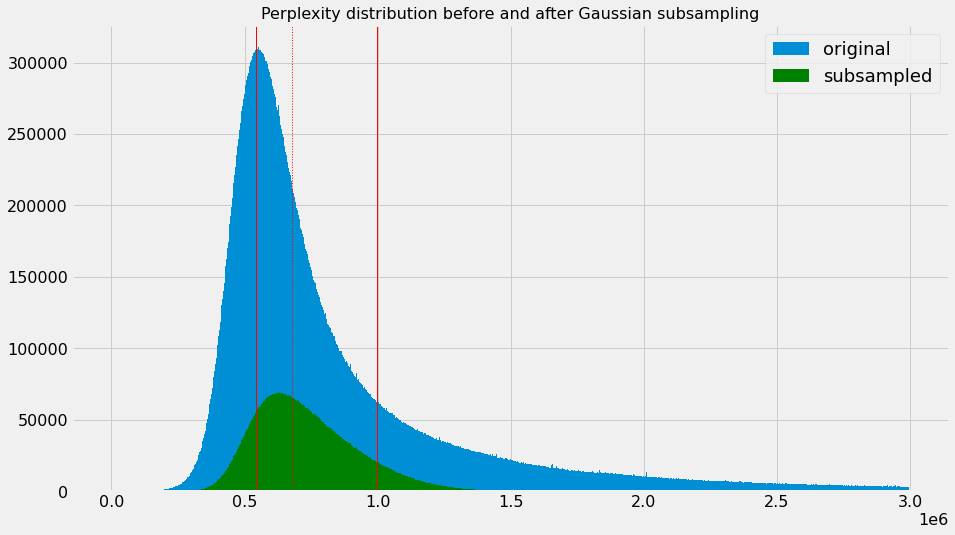

In [60]:
plot_subsample(data, data_sub_adj2)

To take a closer look, we show only the distribution for the subsampled data

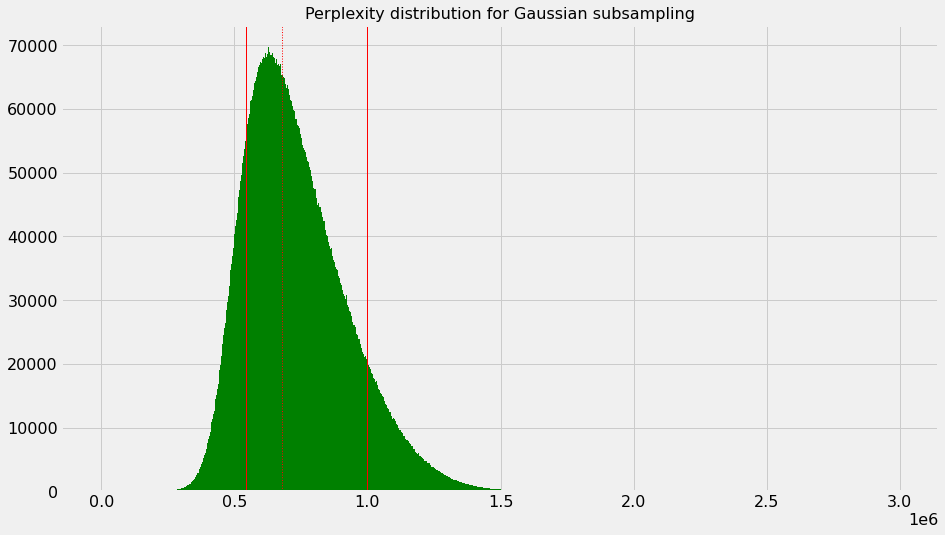

In [61]:
plot_subsample(None, data_sub_adj2)

## 5. Annex: piecewise sampling

A different, and more direct approach, is to subsample with different ratios on the three regions

In [62]:
def subsample_frac(data: np.ndarray, frac: float) -> np.ndarray:
    return data[uniform.rvs(size=len(data)) < frac]

def subsample_byregion(data: np.ndarray, frac: float, q1: float, q2: float) -> np.ndarray:
    data1 = subsample_frac(data[data<qr[0]], q1/0.25*frac)
    data2 = subsample_frac(data[(data>=qr[0]) & (data<=qr[2])], (1-q1-q2)/0.5*frac)
    data3 = subsample_frac(data[data>qr[2]], q2/0.25*frac)
    return np.hstack([data1, data2, data3])

In [63]:
%%time
data_piece = subsample_byregion(data, 0.20, 0.15, 0.10)

CPU times: user 2.15 s, sys: 5.13 s, total: 7.28 s
Wall time: 7.29 s


In [64]:
len(data_piece)/len(data)

0.20003226

In [65]:
check_regions(data_piece)

Probability mass below Pa: 0.1500345994191137
Probability mass above Pb: 0.10010635284528606


This method obtains also the desired values. However, the resulting distribution is quite different:

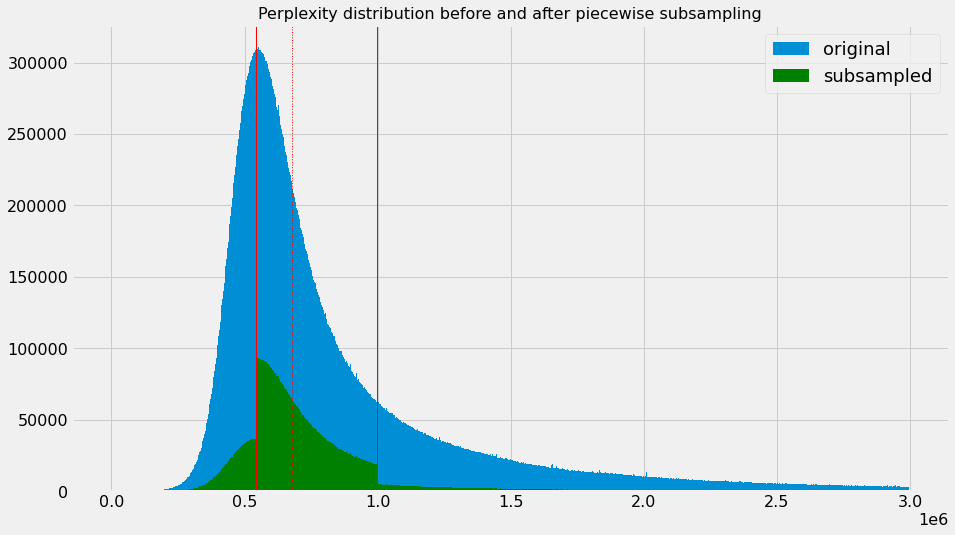

In [66]:
plot_subsample(data, data_piece, 'piecewise subsampling')

The main differences with Gaussian subsampling are:
 * There are discontinuities at the region boundaries, so that perplexity values at both sides of the boundary get quite different sampling ratios. We lose the gradual transitions of Gaussian sampling
 * Inside each region the pattern is roughly equivalent to the original shape, though obviously subsampled. This means that we keep the long tail behaviour of the original distribution. While for Gaussian weighting the shape of the weighting function cuts down the long tails, concentrating the distribution near the quartile boundaries